To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=OFF ..
+ make -j 4
+ make install

In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../build_x/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, SparsePoints, train_gap_model
from rascal.models.IP_ase_interface import ASEMLCalculator
from rascal.neighbourlist import AtomsList
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score,FPSFilter


Bad key "text.kerning_factor" on line 4 in
/local/ssd/miniconda/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import urllib.request
# a collection of distorted ethanol molecules from the ANI-1 dataset 
# (see https://github.com/isayev/ANI1_dataset) with energies and forces computed using DFTB+ 
# (see https://www.dftbplus.org/)
url = 'https://raw.githubusercontent.com/cosmo-epfl/librascal-example-data/833b4336a7daf471e16993158322b3ea807b9d3f/inputs/molecule_conformers_dftb.xyz'
# Download the file from `url`, save it in a temporary directory and get the
# path to it (e.g. '/tmp/tmpb48zma.txt') in the `structures_fn` variable:
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmpt5ab_86j'

# Utility functions

In [3]:
def extract_ref(frames,info_key='dft_formation_energy_per_atom_in_eV',array_key='zeros'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f


# Build a Force Field

In [4]:
# Total number of structure to load
N = 10
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = read(structures_fn,':{}'.format(N))
# frames = [read('../reference_data/inputs/diamond_cubic_distorted.json')]
# frames += [read('../reference_data/inputs/diamond_2atom_distorted.json')]

np.random.seed(10)
frames[0].positions += np.random.rand(len(frames[0]),3)
frames[0].wrap(eps=1e-10)
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)



# split the structures in 2 sets
ids = list(range(N))
np.random.seed(10)
# np.random.shuffle(ids)

train_ids = ids[:f]
test_ids = ids[f:]

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    1: -6.492647589968434,
    6: -38.054950840332474,
    8: -83.97955098636527,
}

In [5]:
# split the dataset in a train and a test set
# y_train, f_train = extract_ref(frames_train,'dftb_energy_eV','dftb_forces_eV_per_Ang')
# y_test, f_test = extract_ref(frames_test,'dftb_energy_eV','dftb_forces_eV_per_Ang')

In [6]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=2., 
              max_radial=2, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              )


soap = SphericalInvariants(**hypers)
# compute the representation of all the structures
managers = soap.transform(frames)

In [7]:
# select the sparse points for the sparse kernel method with CUR on the whole training set
n_pseudo = {1:2,6:2,8:2}
# n_pseudo = {6:8}
compressor = FPSFilter(soap, n_pseudo, act_on='sample per species')
X_pseudo = compressor.select_and_filter(managers)

xs = X_pseudo.get_features()
n_sparse,n_feat = xs.shape
masks = {sp:np.zeros(n_sparse,dtype=bool) for sp in n_pseudo}
ii = 0
for sp, mask in masks.items():
    mask[ii:ii+n_pseudo[sp]] = 1
    ii = ii+n_pseudo[sp]
masks

The number of pseudo points selected by central atom species is: {1: 2, 6: 2, 8: 2}
Selecting species: 1
Selecting species: 6
Selecting species: 8


{1: array([ True,  True, False, False, False, False]),
 6: array([False, False,  True,  True, False, False]),
 8: array([False, False, False, False,  True,  True])}

In [9]:
# set up the sparse kernel and compute the representation for the train set
zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

managers_train = managers.get_subset(train_ids)

In [10]:
ij = managers_train.get_ij()
ij.shape

(268, 4)

In [20]:
ij

array([[ 0,  0,  8,  8],
       [ 0,  1,  8,  6],
       [ 0,  4,  8,  1],
       ...,
       [79, 79,  1,  1],
       [79, 73,  1,  6],
       [79, 78,  1,  1]], dtype=int32)

In [11]:
n_atoms = 0
n_neigh = 0
sps = []
for manager in managers_train:
    n_atoms += len(manager)
    for at in manager:
        n_neigh += at.nb_pairs
        sps.append(at.atom_type)
n_atoms, n_neigh 

(80, 268)

In [12]:
KNM_ref = kernel(managers_train, X_pseudo,(False, False))
X = managers_train.get_features(soap).reshape((n_atoms,n_feat))
kk = np.zeros((len(frames_train), n_sparse))
ii = 0
for iff,ff in enumerate(frames_train):
    for sp in ff.get_atomic_numbers():
        kk[iff,masks[sp]] += np.dot(X[ii],xs[masks[sp]].T)
        ii += 1
np.allclose(KNM_ref, kk)

True

In [23]:
KNM_ref = kernel(managers_train, X_pseudo,(True, False))
KNM_ref.shape

(240, 6)

In [24]:
X_der = managers_train.get_features_gradient(soap).reshape((n_neigh,3,n_feat))

In [29]:
KNM = np.zeros((n_atoms,3,n_sparse))
for ii,(i,j,i_sp,j_sp) in enumerate(ij):
    sp = i_sp
    KNM[j, 0, masks[sp]] += np.dot(X_der[ii,0],xs[masks[sp]].T)
    KNM[j, 1, masks[sp]] += np.dot(X_der[ii,1],xs[masks[sp]].T)
    KNM[j, 2, masks[sp]] += np.dot(X_der[ii,2],xs[masks[sp]].T)
    
KNM = KNM.reshape((-1,n_sparse))

In [30]:
np.allclose(KNM_ref,KNM)

True

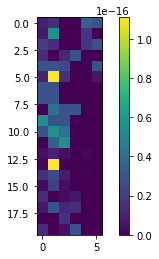

In [31]:
plt.imshow(np.abs(KNM_ref-KNM)[:20])
plt.colorbar()

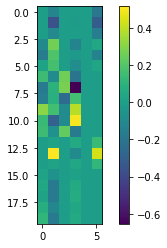

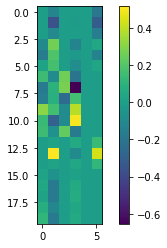

In [32]:
plt.imshow(KNM_ref[:20])
plt.colorbar()
plt.show()
plt.imshow(KNM[:20])
plt.colorbar()
plt.show()

In [33]:
# build the KNM matrix for training with forces and energies (see train_gap_model for more details)
KNM = kernel(managers_train, X_pseudo)
KNM_down = kernel(managers_train, X_pseudo, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])
del KNM_down
KNM_down = []


In [73]:
# train a GAP model 
model = train_gap_model(kernel, managers_train, KNM, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[1e-12, 1e-12], jitter=1e-13)
# model = train_gap_model(kernel, managers_train, KNM[:len(managers_train)], X_pseudo, y_train, self_contributions, 
#                         grad_train=None, lambdas=[1e-6, 1e-2], jitter=1e-7)


NameError: name 'y_train' is not defined

In [ ]:
# # the model can be serialized to a python dictionary
# model_serialized = to_dict(model)
# # and recovered from such dictionary
# model_copy = from_dict(model_serialized)

In [ ]:
# make predictions on the test set
managers_test = managers.get_subset(test_ids)
y_pred = model.predict(managers_test)
f_pred = model.predict_forces(managers_test)

In [ ]:
# basic assessement of the quality of the trained model
print_score(y_pred, y_test)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot(y_test, y_pred, 'o')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV]")
plt.ylabel("reference energies [eV]")

In [ ]:
# save the model to a file in json format for future use
dump_obj('/tmp/mymodel.json', model)

# Test the model on dimer configurations

In [ ]:
# you can load the previously trained model
model = load_obj('/tmp/mymodel.json')

In [ ]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[1,1],[6,6],[8,8],[6,1],[8,1],[6,8]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

In [ ]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
e_pairs = model.predict(X)
e_pairs -= e_pairs.mean()

In [ ]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# Use it to run a MD simulation

In [ ]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [ ]:
from rascal.models.IP_ase_interface import ASEMLCalculator

In [ ]:
# you can load the previously trained model
model = load_obj('/tmp/mymodel.json')
soap = model.get_representation_calculator()
calc = ASEMLCalculator(model, soap)

In [ ]:
%%time
log_fn = '/tmp/md.log'
filename = '/tmp/md.traj'

T = 200

atoms = read(structures_fn, 0)

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, 0.5 * units.fs, units.kB * T, 0.002)

dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
           peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=10)

dyn.run(2000)

In [ ]:
view(read(filename,':'))